<a href="https://colab.research.google.com/github/SJinji/reinforcement_project/blob/main/RL_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Frozen Lake with Reinforcement Learning**
### BY Mengyu LIANG, Nhat Mai NGUYEN, Jinji SHEN

In [ ]:
import numpy as np
from copy import deepcopy
import enum
import torch
import time
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# **Environment**

Self-buid the environment

In [ ]:
# define the possible actions as an enumeration
class Action(enum.Enum):
    Left = 0
    Right = 1
    Up = 2
    Down = 3

# define the environment class
class Environment:
    def __init__(self):
        # initialize the map, which is a 4x4 grid of characters
        self.map = np.array([['S', 'F', 'F', 'F'], 
                             ['F', 'H', 'F', 'H'], 
                             ['F', 'F', 'F', 'H'], 
                             ['H', 'F', 'F', 'G']])
        # define the action space as an array of possible actions
        self.action_space = np.array([Action.Left, Action.Right, Action.Up, Action.Down])
        # define the state space as an array of integers from 0 to 15
        self.state_space = [i for i in range(np.array(self.map).size)]

        # define the states where certain actions are invalid (i.e. the agent would go off the map)
        self.no_left_states = [4, 8, 0, 12]
        self.no_right_states = [7, 11, 3, 15]
        self.no_up_states = [1, 2, 0, 3]
        self.no_down_states = [13, 14, 12, 15]

        # initialize the current state to be the top-left corner of the map
        self.current_state = 0

    # return the action space
    def get_action_space(self):
        return self.action_space

    # return the state space
    def get_state_space(self):
        return self.state_space

    # select a random action from the action space
    def get_random_action(self):
        return np.random.choice(self.action_space)

    # take a step in the environment, given an action index
    def step(self, action_index):
        # convert the action index to an Action enumeration
        action = Action(action_index)

        # check if the action is invalid (i.e. would make the agent go off the map)
        if self.invalid_action(action):
            # if so, return the current state, reward of 0, and False to indicate that the episode is not over
            return self.current_state, 0, False

        # update the current state based on the action
        if action == Action.Left:
            self.current_state -= 1
        elif action == Action.Right:
            self.current_state += 1
        elif action == Action.Up:
            self.current_state -= 4
        else:
            self.current_state += 4

        # get the row and column indices of the current state
        row, column = self.get_indices_of_current_state()
        # get the character at the current state's position on the map
        letter = self.map[row][column]

        # if the current state is a 'S' or 'F', return the current state, reward of 0, and False to indicate that the episode is not over
        if letter == 'S' or letter == 'F':
            return self.current_state, 0, False
        # if the current state is a 'G', return the current state, reward of 1, and True to indicate that the episode is over
        elif letter == 'G':
            return self.current_state, 1, True
        # if the current state is a 'H', return the current state, reward of 0, and True to indicate that the episode is over
        else:
            return self.current_state, 0, True

    def invalid_action(self, action):
        # Check if the chosen action is not allowed in the current state
        if (action == Action.Left and self.current_state in self.no_left_states) or \
           (action == Action.Right and self.current_state in self.no_right_states) or \
           (action == Action.Up and self.current_state in self.no_up_states) or \
           (action == Action.Down and self.current_state in self.no_down_states):
            return True

        return False

    def get_indices_of_current_state(self):
        # Convert the current state to a row and column index on the map
        temp = 0
        for i in range(len(self.map)):
            for j in range(len(self.map[0])):
                if temp == self.current_state:
                    return i, j
                temp += 1

    def reset(self):
        # reset the current state to the starting state (which is 0 in this case) and returns the new current state
        self.current_state = 0
        return self.current_state

    def print_current_state(self):
        # make a copy of the map
        temp_map = deepcopy(self.map)
        row, column = self.get_indices_of_current_state()
        # replace the cell at the current state with an 'X' symbol in the copy
        temp_map[row][column] = 'X'

        # prints the map with the current state symbol to the console.
        for r in temp_map:
            print(r[0], r[1], r[2], r[3])
        print()

Check the environment

In [ ]:
# create an instance of the Environment class
env = Environment()

# print the current state
env.print_current_state()

# take a step with a random action
action = env.get_random_action()
next_state, reward, done = env.step(action.value)
print("Action taken:", action)
print("Next state:", next_state)
print("Reward received:", reward)
print("Done?", done)

# reset the environment
env.reset()

X F F F
F H F H
F F F H
H F F G

Action taken: Action.Up
Next state: 0
Reward received: 0
Done? False


0

In [ ]:
# Total number of States and Actions
number_of_states = len(env.get_state_space())
number_of_actions = len(env.get_action_space())
print( "States = ", number_of_states)
print( "Actions = ", number_of_actions)

States =  16
Actions =  4


# **Agents**

In [ ]:
# Parameters
num_episodes = 1000
gamma = 0.95 # Discount on reward
learning_rate = 0.9 # Factor to balance the ratio of action taken based on past experience to current situtation
egreedy_start = 0.7 # exploit vs explore to find action, start with 70% random actions to explore the environment
egreedy_decay = 0.999 # and with time, using decay to shift to more optimal actions learned from experience
egreedy_final = 0.1 # lower limit for egreedy during decaying

### **Q_learning**

In [ ]:
def train_qlearning(gamma,learning_rate):
  # Create empty lists to store step, reward, egreedy
  Q_steps_total = []
  Q_rewards_total = []
  Q_egreedy_total = []
  egreedy = egreedy_start
  # Create table to store Q-value (initialized with 0)
  Q = torch.zeros([number_of_states, number_of_actions])

  # Train the agent
  for i_episode in range(num_episodes):
    # Resets the environment
    state = env.reset()
    step = 0

    while True:
        step += 1
        # Take random action with probablity = egreedy
        random_for_egreedy = torch.rand(1)[0]
        if random_for_egreedy > egreedy:
            q_values = [Q[state][action] for action in [0,1,2,3]]  
            max_q = max(q_values)
            if q_values.count(max_q) > 1:
              best_actions = [i for i in [0,1,2,3] if q_values[i] == max_q]
              action = random.choice(best_actions) # randomly choose best action that has the same max Q
            else:
              action = q_values.index(max_q)
        else:
            action = env.get_random_action().value
        # Decaying egreedy until reaching egreedy_final          
        if egreedy > egreedy_final:
            egreedy *= egreedy_decay
        # Get environment info after taking action
        new_state, reward, done = env.step(action)
        # Filling the Q-Table
        current_q = Q[state, action] # get the current Q-value
        update_q = (1 - learning_rate)* current_q + learning_rate * (reward + gamma * torch.max(Q[new_state])) # get the updated Q-value
        Q[state, action] = update_q
        state = new_state
        # If the episode ends, update steps_total, rewards_total, egreedy_total
        if done:
            Q_steps_total.append(step)
            Q_rewards_total.append(reward)
            Q_egreedy_total.append(egreedy)
            #print('Episode: {} Reward: {} Steps Taken: {}'.format(i_episode,reward, step))
            break
  return Q, Q_steps_total, Q_rewards_total, Q_egreedy_total

Q, Q_steps_total, Q_rewards_total, Q_egreedy_total = train_qlearning(gamma,learning_rate)

### **SARSA**

In [ ]:
def train_sarsa(gamma,learning_rate):
  # Create empty lists to store step, reward, egreedy
  S_steps_total = []
  S_rewards_total = []
  S_egreedy_total = []
  egreedy = egreedy_start
  # Create table to store Q-value (initialized with 0)
  S_Q = torch.zeros([number_of_states, number_of_actions])

  # Train the agent
  for i_episode in range(num_episodes):
    # Resets the environment
    state = env.reset()
    step = 0

    while True:
        step += 1
        # Take random action with probablity = egreedy
        random_for_egreedy = torch.rand(1)[0]
        if random_for_egreedy > egreedy:     
            q_values = [S_Q[state][action] for action in [0,1,2,3]]  
            max_q = max(q_values)
            if q_values.count(max_q) > 1:
              best_actions = [i for i in [0,1,2,3] if q_values[i] == max_q]
              action = random.choice(best_actions) # randomly choose best action that has the same max Q
            else:
              action = q_values.index(max_q)
        else:
            action = env.get_random_action().value
        # Decaying egreedy until reaching egreedy_final          
        if egreedy > egreedy_final:
            egreedy *= egreedy_decay
        # Get environment info after taking action
        new_state, reward, done = env.step(action)

        # Filling the Q-Table
        current_q = S_Q[state, action] # get the current Q-value
        random_values = S_Q[new_state] + torch.rand(1,number_of_actions) / 1000      
        next_action = torch.max(random_values,1)[1][0]  
        next_action = next_action.item() # get the action for next state
        next_q = S_Q[new_state, next_action] # get the q-value for next state, next action 
        update_q = (1 - learning_rate)* current_q + learning_rate * (reward + gamma * next_q) # get the updated Q-value
        S_Q[state, action] = update_q
        state = new_state
        # If the episode ends, update steps_total, rewards_total, egreedy_total
        if done:
            S_steps_total.append(step)
            S_rewards_total.append(reward)
            S_egreedy_total.append(egreedy)
            #print('Episode: {} Reward: {} Steps Taken: {}'.format(i_episode,reward, step))
            break
  return S_Q, S_steps_total, S_rewards_total, S_egreedy_total

S_Q, S_steps_total, S_rewards_total, S_egreedy_total = train_sarsa(gamma,learning_rate)

### **Random**

In [ ]:
# Create empty lists to store step, reward, egreedy
R_steps_total = []
R_rewards_total = []

# Train the agent
for i_episode in range(num_episodes):
    # Resets the environment
    state = env.reset()
    step = 0

    while True:
        step += 1
        # Take random action
        action = env.get_random_action().value
        # Get environment info after taking action
        new_state, reward, done = env.step(action)
        # Go to next state
        state = new_state
        # If the episode ends, update steps_total, rewards_total, egreedy_total
        if done:
            R_steps_total.append(step)
            R_rewards_total.append(reward)
            #print('Episode: {} Reward: {} Steps Taken: {}'.format(i_episode,reward, step))
            break

# **Insights**

In [ ]:
# Episode finished and average step across agents
print("=========================== Q-learning =============================")        
print("Percent of episodes finished successfully: {0}".format(sum(Q_rewards_total)/num_episodes))
print("Percent of episodes finished successfully (last 100 episodes): {0}".format(sum(Q_rewards_total[-100:])/100))
print("Average number of steps: %.2f" % (sum(Q_steps_total)/num_episodes))
print("Average number of steps (last 100 episodes): %.2f" % (sum(Q_steps_total[-100:])/100))

print("============================= SARSA ================================")        
print("Percent of episodes finished successfully: {0}".format(sum(S_rewards_total)/num_episodes))
print("Percent of episodes finished successfully (last 100 episodes): {0}".format(sum(S_rewards_total[-100:])/100))
print("Average number of steps: %.2f" % (sum(S_steps_total)/num_episodes))
print("Average number of steps (last 100 episodes): %.2f" % (sum(S_steps_total[-100:])/100))

print("============================= Random ===============================")        
print("Percent of episodes finished successfully: {0}".format(sum(R_rewards_total)/num_episodes))
print("Percent of episodes finished successfully (last 100 episodes): {0}".format(sum(R_rewards_total[-100:])/100))
print("Average number of steps: %.2f" % (sum(R_steps_total)/num_episodes))
print("Average number of steps (last 100 episodes): %.2f" % (sum(R_steps_total[-100:])/100))

=========================== Q-learning =============================
Percent of episodes finished successfully: 0.812
Percent of episodes finished successfully (last 100 episodes): 0.88
Average number of steps: 6.49
Average number of steps (last 100 episodes): 6.43
============================= SARSA ================================
Percent of episodes finished successfully: 0.737
Percent of episodes finished successfully (last 100 episodes): 0.85
Average number of steps: 6.49
Average number of steps (last 100 episodes): 6.48
============================= Random ===============================
Percent of episodes finished successfully: 0.015
Percent of episodes finished successfully (last 100 episodes): 0.01
Average number of steps: 7.64
Average number of steps (last 100 episodes): 7.63


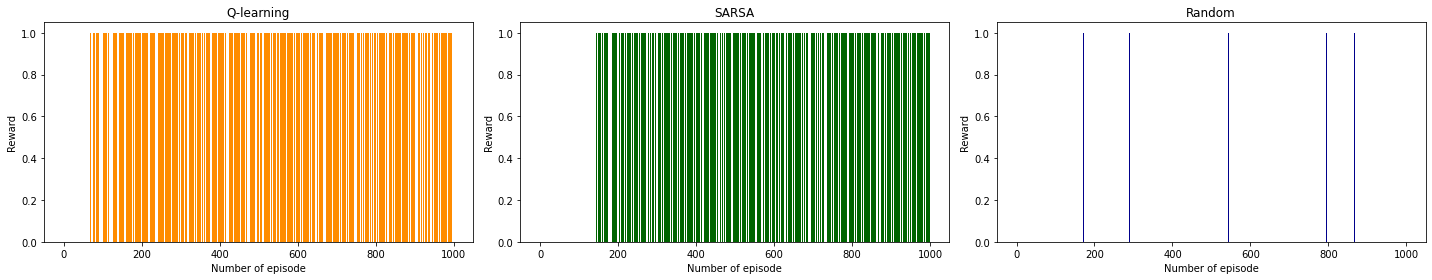

In [ ]:
# Reward per episode across agents
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 4))
# Plot the first subplot
axs[0].bar(torch.arange(len(Q_rewards_total)), Q_rewards_total, color='darkorange')
axs[0].set_title('Q-learning')
axs[0].set_xlabel('Number of episode')
axs[0].set_ylabel('Reward')
# Plot the second subplot
axs[1].bar(torch.arange(len(S_rewards_total)), S_rewards_total, color='darkgreen')
axs[1].set_title('SARSA')
axs[1].set_xlabel('Number of episode')
axs[1].set_ylabel('Reward')
# Plot the third subplot
axs[2].bar(torch.arange(len(R_rewards_total)), R_rewards_total, color='darkblue')
axs[2].set_title('Random')
axs[2].set_xlabel('Number of episode')
axs[2].set_ylabel('Reward')
# Show the plot
plt.tight_layout()
plt.show()

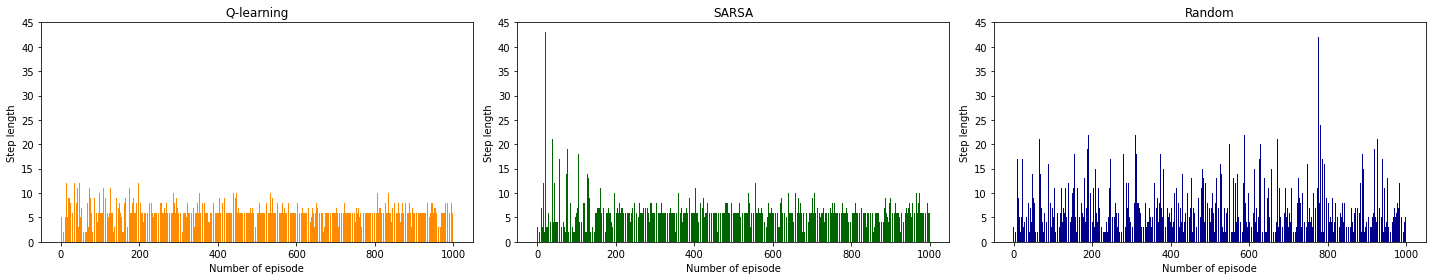

In [ ]:
# Step length across agent
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 4))
y_lim = (0, max(max(Q_steps_total), max(S_steps_total), max(R_steps_total)) + 1)
# Plot the first subplot
axs[0].bar(torch.arange(len(Q_steps_total)), Q_steps_total, color='darkorange')
axs[0].set_ylim(y_lim)
axs[0].set_title('Q-learning')
axs[0].set_xlabel('Number of episode')
axs[0].set_ylabel('Step length')
# Plot the second subplot
axs[1].bar(torch.arange(len(S_steps_total)), S_steps_total, color='darkgreen')
axs[1].set_ylim(y_lim)
axs[1].set_title('SARSA')
axs[1].set_xlabel('Number of episode')
axs[1].set_ylabel('Step length')
# Plot the third subplot
axs[2].bar(torch.arange(len(R_steps_total)), R_steps_total, color='darkblue')
axs[2].set_ylim(y_lim)
axs[2].set_title('Random')
axs[2].set_xlabel('Number of episode')
axs[2].set_ylabel('Step length')
# Show the plot
plt.tight_layout()
plt.show()

We can see that at the beginning the steps taken in an episode is large because we have high number of random actions. As we learn from experience, we start to take more informed steps , hence resulting is fewer steps and more success rate.

In [ ]:
# For each state, get the state-value by taking the max value among the actions
Q_state_value = torch.max(Q, dim=1).values.numpy()
print(Q_state_value)
S_state_value = torch.max(S_Q, dim=1).values.numpy()
print(S_state_value)

[0.77378076 0.81450605 0.85737485 0.81449795 0.81450605 0.
 0.9024999  0.         0.85737485 0.9024999  0.9499999  0.
 0.         0.9499999  1.         0.        ]
[0.77378076 0.7350917  0.         0.         0.81450605 0.
 0.7330555  0.         0.85737485 0.9024999  0.85737485 0.
 0.         0.9499999  1.         0.        ]


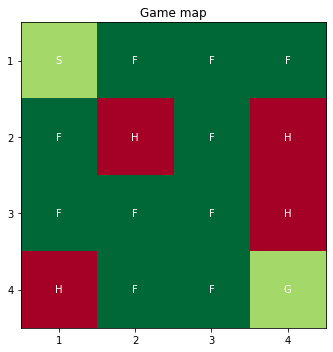

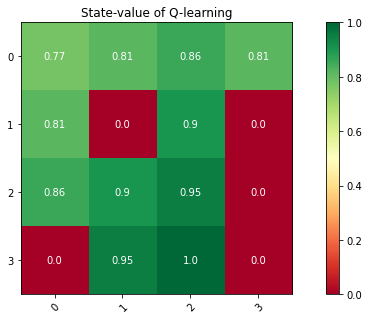

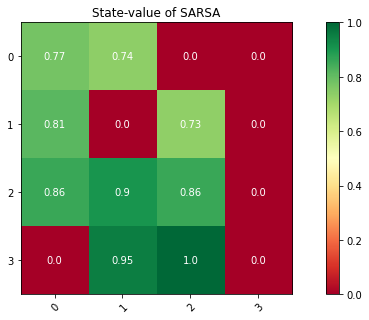

In [ ]:
# Reshape data & get game map
Q_data = np.array(Q_state_value).reshape((4, 4))
S_data = np.array(S_state_value).reshape((4, 4))
map = np.array([['S', 'F', 'F', 'F'], 
          ['F', 'H', 'F', 'H'], 
          ['F', 'F', 'F', 'H'], 
          ['H', 'F', 'F', 'G']])

map_num = np.array([[7, 10, 10, 10], 
                    [10, 0, 10, 0], 
                    [10, 10, 10, 0], 
                    [0, 10, 10, 7]])

# Plot the game map
fig, ax = plt.subplots(figsize=(12,5))
im = ax.imshow(map_num, cmap='RdYlGn',vmin = 0, vmax=10)
# Show all ticks and ticklabels
ax.set_xticks(range(len(map[0])))
ax.set_yticks(range(len(map)))
ax.set_xticklabels(range(1, len(map[0])+1))
ax.set_yticklabels(range(1, len(map)+1))
# Add text annotations for each cell
for i in range(len(map)):
    for j in range(len(map[0])):
        text = ax.text(j, i, map[i][j],
                       ha="center", va="center", color="white")
# Set title and show plot
ax.set_title("Game map")
fig.tight_layout()
plt.show()

# Plot the state value for both agents
def plot_state_value(data, agent_name):
  # Plot grid
  fig, ax = plt.subplots(figsize=(12,5))
  im = ax.imshow(data, cmap='RdYlGn')
  # Add colorbar
  cbar = ax.figure.colorbar(im, ax=ax)
  # Set tick labels
  ax.set_xticks(np.arange(data.shape[1]))
  ax.set_yticks(np.arange(data.shape[0]))
  ax.set_xticklabels(np.arange(4))
  ax.set_yticklabels(np.arange(4))
  # Rotate tick labels and set alignment
  plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
  # Loop over data dimensions and create text annotations
  for i in range(data.shape[0]):
      for j in range(data.shape[1]):
          text = ax.text(j, i, round(data[i, j],2),
                       ha="center", va="center", color="white")
  # Set title and show plot
  ax.set_title(f"State-value of {agent_name}")
  plt.show()

plot_state_value(Q_data,"Q-learning")
plot_state_value(S_data,"SARSA")

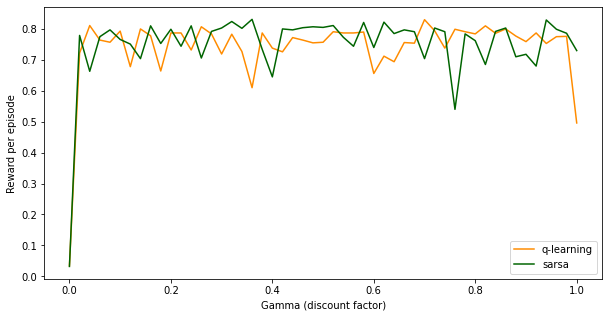

In [ ]:
# Hold other variables
learning_rate = 0.9
egreedy_start = 0.7
egreedy_decay = 0.999
egreedy_final = 0.1

# Agent performance sensitivity to gamma
gamma_range = np.arange(0, 1.02, 0.02)
reward_per_episode_qlearn = []
reward_per_episode_sarsa = []

for gamma in gamma_range:
  # Calculate reward for q-learning
  Q, Q_steps_total, Q_rewards_total, Q_egreedy_total = train_qlearning(gamma,learning_rate)
  reward_per_episode = np.average(Q_rewards_total)
  reward_per_episode_qlearn.append(reward_per_episode)
  # Calculate reward for sarsa
  S, S_steps_total, S_rewards_total, S_egreedy_total = train_sarsa(gamma,learning_rate)
  reward_per_episode = np.average(S_rewards_total)
  reward_per_episode_sarsa.append(reward_per_episode)

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(gamma_range, reward_per_episode_qlearn,label="q-learning", color = 'darkorange')
ax.plot(gamma_range, reward_per_episode_sarsa,label="sarsa", color = 'darkgreen')
ax.set_xlabel('Gamma (discount factor)')
ax.set_ylabel('Reward per episode')
ax.legend()
plt.show()

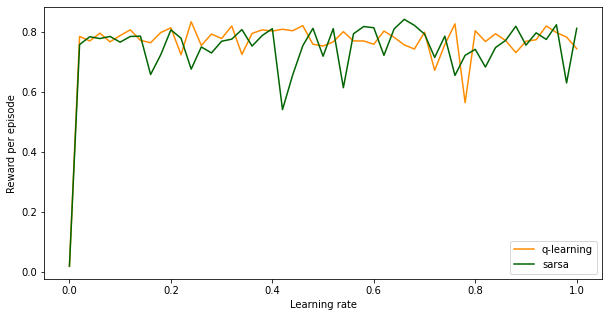

In [ ]:
# Hold other variables
gamma = 0.95
egreedy_start = 0.7 
egreedy_decay = 0.999 
egreedy_final = 0.1 

# Agent performance sensitivity to learning rate
lr_range = np.arange(0, 1.02, 0.02)
reward_per_episode_qlearn = []
reward_per_episode_sarsa = []

for learning_rate in lr_range:
  # Calculate reward for q-learning
  Q, Q_steps_total, Q_rewards_total, Q_egreedy_total = train_qlearning(gamma,learning_rate)
  reward_per_episode = np.average(Q_rewards_total)
  reward_per_episode_qlearn.append(reward_per_episode)
  # Calculate reward for sarsa
  S, S_steps_total, S_rewards_total, S_egreedy_total = train_sarsa(gamma,learning_rate)
  reward_per_episode = np.average(S_rewards_total)
  reward_per_episode_sarsa.append(reward_per_episode)

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(lr_range, reward_per_episode_qlearn,label="q-learning",color = 'darkorange')
ax.plot(lr_range, reward_per_episode_sarsa,label="sarsa",color = 'darkgreen')
ax.set_xlabel('Learning rate')
ax.set_ylabel('Reward per episode')
ax.legend()
plt.show()

In [ ]:
# Hold other variables
learning_rate = 0.9
gamma = 0.95

# Agent performance sensitivity to epsilon
epsilon_range = np.arange(0.1,0.7,0.05)
decay_range = np.arange(1,0.8,-0.01)
epsilon_and_decay = [(epsilon, decay) for epsilon in epsilon_range for decay in decay_range]

reward_per_episode_qlearn = []
reward_per_episode_sarsa = []

for element in epsilon_and_decay:
  egreedy_start = element[0]
  egreedy_decay = element[1]
  # Calculate reward for q-learning
  Q, Q_steps_total, Q_rewards_total, Q_egreedy_total = train_qlearning(gamma,learning_rate)
  reward_per_episode = np.average(Q_rewards_total)
  reward_per_episode_qlearn.append(reward_per_episode)
  # Calculate reward for sarsa
  S, S_steps_total, S_rewards_total, S_egreedy_total = train_sarsa(gamma,learning_rate)
  reward_per_episode = np.average(S_rewards_total)
  reward_per_episode_sarsa.append(reward_per_episode)

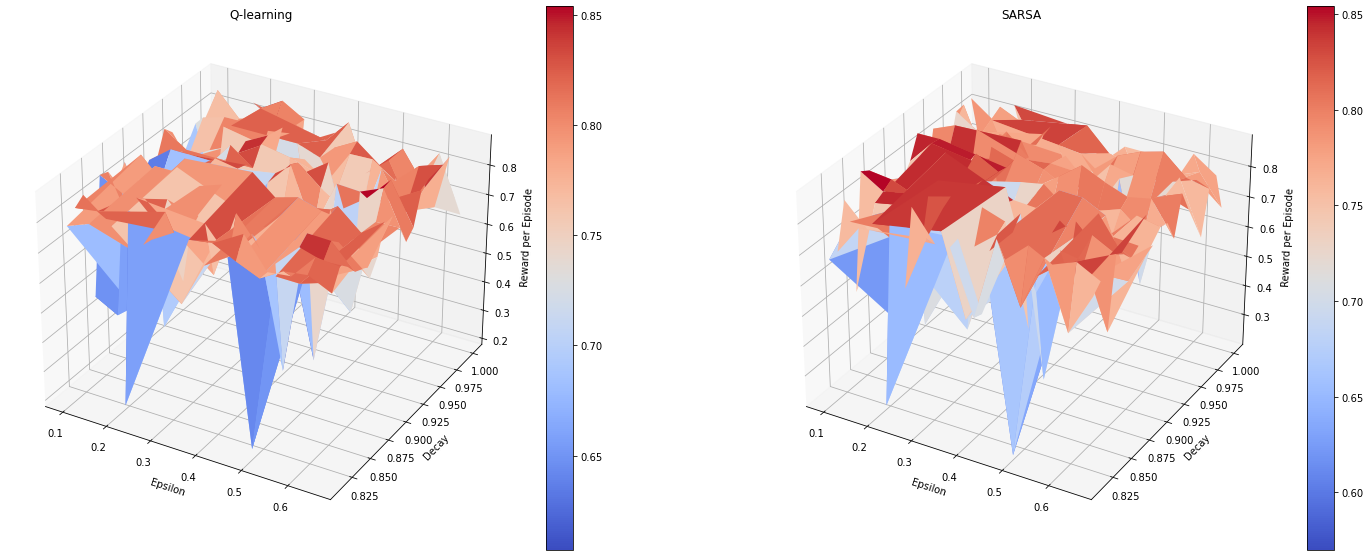

In [ ]:
# Get the values
x = np.array(list(set([i[0] for i in epsilon_and_decay])))
y = np.array(list(set([i[1] for i in epsilon_and_decay])))
z_q = np.array(reward_per_episode_qlearn)
z_s = np.array(reward_per_episode_sarsa)
# Define the meshgrid for the surface plot
X, Y = np.meshgrid(x, y)
Z_q = z_q.reshape((len(y),len(x)))
Z_s = z_s.reshape((len(y),len(x)))

# Create a 3D plot with a surface plot
fig = plt.figure(figsize=(25, 10))
# Plot Q-learning
ax = fig.add_subplot(121, projection='3d')
surf = ax.plot_surface(X, Y, Z_q, cmap='coolwarm')
ax.set_xlabel('Epsilon')
ax.set_ylabel('Decay')
ax.set_zlabel('Reward per Episode')
ax.set_title('Q-learning')
fig.colorbar(surf)
# Plot SARSA
ax = fig.add_subplot(122, projection='3d')
surf = ax.plot_surface(X, Y, Z_s, cmap='coolwarm')
ax.set_xlabel('Epsilon')
ax.set_ylabel('Decay')
ax.set_zlabel('Reward per Episode')
ax.set_title('SARSA')
fig.colorbar(surf)
plt.show()